<a href="https://colab.research.google.com/github/heitorabqg/datascientist/blob/master/PSI5892_autodiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para abrir o notebook no Google Colab, altere o domínio `github.com` para `githubtocolab.com`

<div class="alert alert-block alert-danger">
Para praticar programação, é importante que você erre, leia as mensagens de erro e tente corrigí-los.
    
Dessa forma, no Google Colab, é importante que você DESATIVE OS RECURSOS DE AUTOCOMPLETAR:

- Menu Ferramentas -> Configurações
- Na janela que é aberta:
  - Seção Editor -> Desativar "Mostrar sugestões de preenchimento de código com base no contexto"
  - Seção Assistência de IA -> Desabilitar itens

Na versão em inglês:

- Menu Tools -> Settings
- Na janela que é aberta:
  - Seção Editor -> Desativar "Show context-powered code completions"
  - Seção AI Assistance -> Desabilitar itens
</div>

# PSI5892 - Aula de Exercícios

# Diferenciação automática

Neste exercício vamos implementar um tipo que utiliza diferenciação automática e vamos utilizá-lo para implementaro algoritmo LMS

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

## Exercício 1

Com base no tipo dual que vimos na aula, vamos implementar as operações de subtração e divisão, para compor uma versão capaz de trabalhar com as quatro operações aritméticas básicas.

A subtração é implementada por meio do método ``__sub__`` e a multiplicação por meio do ``__mul__``. Lembre de incluir os métodos ``__rsub__`` e ``__rmul__`` para que o tipo dual funcione no caso de fazer uma operação do tipo ``x - D`` ou ``x * D``, com ``x`` sendo um objeto que não é do tipo dual e ``D`` sendo um objeto do tipo dual.

In [9]:
class D:
    def __init__(self, x, xd):
        self.x = x
        self.xd = xd

    def __add__(self, other):
        if not isinstance(other, D):
            other = D(other, 0)
        return D(self.x + other.x, self.xd + other.xd)

    def __radd__(self, lhs):
        return self + lhs

    def __truediv__(self, other):
        if not isinstance(other, D):
            other = D(other, 0)
        return D(self.x / other.x, (self.xd * other.x - self.x * other.xd) / (other.x**2))

    def __rtruediv__(self, lhs):
        if not isinstance(lhs, D):
            lhs = D(lhs, 0)
        return lhs / self

    #############
    # Complete o código

    def __sub__(self, other):
        if not isinstance(other, D):
             other = D(other, 0)
        return D(self.x - other.x, self.xd - other.xd)



    def __rsub__(self, lhs):
        if not isinstance(lhs, D):
            lhs = D(lhs, 0)
        return lhs - self


    def __mul__(self, other):
        if not isinstance(other, D):
            other = D(other, 0)
        return D(self.x * other.x, self.xd * other.x + self.x * other.xd)


    def __rmul__(self, lhs):
        if not isinstance(lhs, D):
            lhs = D(lhs, 0)
        return lhs * self

    def __pow__(self, other):
        if not isinstance(other, D):
            other = D(other, 0)
        return D(self.x ** other.x, (other.x * (self.x) ** (other.x - 1)) * self.xd)


    #############

    def __repr__(self):
        return f"{self.x} + {self.xd}ϵ"

Agora teste o tipo ``D`` com operações de subtração e divisão:

In [10]:
x_1 = 7
x_1_D = D(x_1, 2)

x_2 = 5
x_2_D = D(x_2, 1)

y = x_1_D - x_2_D # deve resultar em D(2, 1)
assert y.x == 2 and y.xd == 1

y = x_1_D - x_2 # deve resultar em D(2, 2)
assert y.x == 2 and y.xd == 2

y = x_1 - x_2_D # deve resultar em D(2, -1)
assert y.x == 2 and y.xd == -1

y = x_1_D * x_2_D # deve resultar em D(35, 17)
assert y.x == 35 and y.xd == 17

y = x_1_D * x_2 # deve resultar em D(35, 10)
assert y.x == 35 and y.xd == 10

y = x_1 * x_2_D # deve resultar em D(35, 7)
assert y.x == 35 and y.xd == 7

## Exercício 2

Agora, vamos implementar o algoritmo LMS usando autodiff. Nesse caso, vale notar que vamos precisar calcular o quadrado do erro e, por isso, precisamos da operação de potenciação, além das operações aritméticas básicas.

Complemente a classe implementada no exercício 1 com o método ``__pow__`` que implementa a operação de potenciação, efetuada quando utilizamos o operador ``**``. Note que nesse caso, precisamos apenas da operação de potenciação do tipo ``x**k``, em ``x`` é um objeto dual e ``k`` é uma constante. Dessa forma, não há a necessidade de implementar o método ``__rpow__``.

In [11]:
#############
# Complete o código

def __mul__(self, other):
        if not isinstance(other, D):
            other = D(other, 0)
        return D(self.x * other.x, self.xd * other.x + self.x * other.xd)


def __rmul__(self, lhs):
        if not isinstance(lhs, D):
            lhs = D(lhs, 0)
        return lhs * self





#############

Agora teste o tipo ``D`` com a operação de potenciação:

In [12]:
x = 2
x_D = D(x, 2)

k = 3

y = x_D ** k # deve resultar em D(8, 24)
assert y.x == 8 and y.xd == 24

Vamos trabalhar com o LMS no contexto do problema das meias luas. Para isso, vamos iniciar gerando dados para treinamento:

In [13]:
def meias_luas(NA, NB, r1, r2, r3):
    """
    dados = meias_luas(NA,NB,r1,r2,r3)
    NA: número de pontos da região A
    NB: número de pontos da região B
    r1, r2 e r3: dados das meias-luas
    """

    Nt = NA + NB  # total de dados de treinamento

    # dados das meia luas
    rmin = r1 - r3 / 2
    rmax = r1 + r3 / 2

    # Pontos da Região A
    a = np.pi * np.random.rand(NA, 1)
    rxy = np.random.uniform(rmin, rmax, (NA, 1))
    xA = rxy * np.cos(a)
    yA = rxy * np.sin(a)
    dA = np.ones((NA, 1))
    pontosA = np.hstack((xA, yA, dA))

    # Pontos da Região B
    a = np.pi * np.random.rand(NB, 1)
    rxy = np.random.uniform(rmin, rmax, (NB, 1))
    xB = rxy * np.cos(a) + r1
    yB = -rxy * np.sin(a) - r2
    dB = -np.ones((NB, 1))
    pontosB = np.hstack((xB, yB, dB))

    # Concatenando e embaralhando os dados
    dados = np.vstack((pontosA, pontosB))
    np.random.shuffle(dados)

    # Figura para mostrar os dados de treino
    fig, ax1 = plt.subplots()
    ax1.plot(xA, yA, ".b")
    ax1.plot(xB, yB, ".r")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(axis="x", color="0.5")
    plt.grid(axis="y", color="0.5")

    return dados

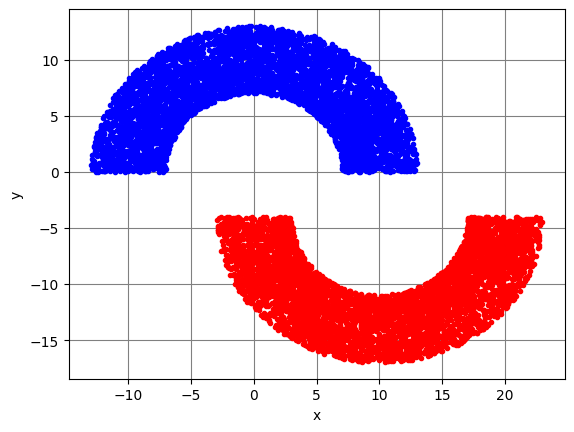

In [14]:
NA = 5000
NB = 5000
Nt = NA + NB  # número de dados de treinamento
r1 = 10
r3 = 6
r2 = 4

dados_treino = meias_luas(NA, NB, r1, r2, r3)

In [15]:
# organizando os dados para entrada do LMS
xtreino = dados_treino[:, [0, 1]]  # sinal de entrada
dtreino = dados_treino[:, [2]]  # sinal desejado

Usando os dados ``x`` e ``d``, implemente o algoritmo LMS usando autodiff. Para isso, toda a computação deve ser implementada usando tipos duais para que os gradientes sejam calculados automaticamente. Leve em conta as seguintes considerações:

- O tipo dual que implementamos é capaz de lidar apenas com escalares. Na prática, é necessário o uso de tipos vetoriais capazes de obter os gradientes de forma automática. Para este exercício, vamos trabalhar com o tipo escalar e fixar o número de coeficientes adaptados pelo LMS em 3 (``M=2`` acrescido de um coeficiente para o bias)
- Lembre-se de que estamos utilizando o modo progressivo para o cálculo dos gradientes. Dessa forma, será necessário executar o cálculo da saída por 3 vezes consecutivas para obter o gradiente para os 2 pesoa e bias, respectivamente.
- Para facilitar a implementação, considere o modo estocástico, em que os pesos são adaptados a cada exemplo de treinamento.

LMS com autodiff
M fixo e igual a 2 - para evitar implementar vetores de dimensão arbitrária

In [16]:
def LMS_FILTER_estocastico_autodiff(x, d, eta, Nt):
    """
    W = LMS_FILTER_estocastico_autodiff(x, d, eta, Nt)
    x: sinal de entrada (Nt x 2)
    d: sinal desejado (Nt x 1)
    eta: passo de adaptação
    Nt: número de dados de treinamento
    """
    M = 2
    # inserimos uma coluna de uns ao vetor de entrada para levar em conta o bias
    x = np.hstack((np.ones((Nt, 1)), x))  # agora cada linha tem [1, x1, x2]

    W = np.zeros((Nt + 1, M + 1))  # armazenamento dos coeficientes (bias, w0, w1)

    for i in range(Nt):
        # valores escalares da amostra i
        xi0 = float(x[i, 0])   # sempre 1 (bias)
        xi1 = float(x[i, 1])   # primeiro atributo
        xi2 = float(x[i, 2])   # segundo atributo
        di = float(d[i, 0])    # desejado para a amostra i

        # pesos atuais (numéricos)
        b_cur = float(W[i, 0])
        w0_cur = float(W[i, 1])
        w1_cur = float(W[i, 2])

        # ------- 1) Atualização do bias -------
        # bias é a variável com parte dual = 1; os demais com parte dual = 0
        B_D = D(b_cur, 1)
        W0_D = D(w0_cur, 0)
        W1_D = D(w1_cur, 0)
        Dd = D(di, 0)  # desejado como dual com parte dual 0

        # saída, erro e custo (MSE) usando objetos D
        y = B_D + W0_D * xi1 + W1_D * xi2
        e = Dd - y
        J = e ** 2

        # atualização do bias (dividimos por 2 conforme explicado)
        b_upd = B_D.x - (eta / 2.0) * J.xd
        W[i + 1, 0] = b_upd

        # ------- 2) Atualização de w0 -------
        # agora usamos o bias atualizado como constante (parte dual = 0)
        B_D = D(b_upd, 0)
        W0_D = D(w0_cur, 1)   # queremos o gradiente em relação a w0
        W1_D = D(w1_cur, 0)

        y = B_D + W0_D * xi1 + W1_D * xi2
        e = Dd - y
        J = e ** 2

        w0_upd = W0_D.x - (eta / 2.0) * J.xd
        W[i + 1, 1] = w0_upd

        # ------- 3) Atualização de w1 -------
        # usamos bias e w0 já atualizados como constantes (parte dual = 0)
        B_D = D(b_upd, 0)
        W0_D = D(w0_upd, 0)
        W1_D = D(w1_cur, 1)   # queremos o gradiente em relação a w1

        y = B_D + W0_D * xi1 + W1_D * xi2
        e = Dd - y
        J = e ** 2

        w1_upd = W1_D.x - (eta / 2.0) * J.xd
        W[i + 1, 2] = w1_upd

    return W


In [ ]:
def LMS_FILTER_estocastico_autodiff(x, d, eta, Nt):
    """
    W = LMS_FILTER_estocastico(x, d, eta, Nt)
    x: sinal de entrada
    d: sinal desejado
    eta: passo de adaptação
    Nt: número de dados de treinamento
    """
    M = 2
    # inserimos uma coluna de uns ao vetor de entrada para levar em conta o bias
    x = np.hstack((np.ones((Nt, 1)), x))

    W = np.zeros((Nt + 1, M + 1))

    for i in range(Nt):
        pass
        # Inicie com o bloco de código para adaptação do bias

        # Crie uma variável dual para cada elemento a respeito do qual desejamos calcular o gradiente da função custo
        # Indique a parte dual igual a 1 para o bias
        #############
        # Complete o código
        # B_D =
        # W0_D =
        # W1_D =
        #############

        # Calcule a saída, o erro, e o valor da da função custo do MSE
        # Tome cuidado para que todas as variáveis alocadas dos dados de treino sejam tratadas como
        # tipos básicos do Python (e não do numpy). Para tanto, use float(<valor escalar do tipo numpy>)
        #############
        # Complete o código
        # y =
        # e =
        # J =
        #############

        # Implemente a atualização do bias usando o gradiente calculado automaticamente
        # Como a variável dual do bias foi criada com a parte dual igual a 1, J.xd vai conter
        # o gradiente de J em relação ao bias
        # Lembre-se que é necessário dividir o passo por 2 para chegar ao mesmo comportamento
        # do algoritmo calculado manualmente
        #############
        # Complete o código
        # B_D =
        #############

        # Por fim, vamos guardar os valores do bias ao longo das iterações em W
        # W[i + 1, 0] = B_D.x

        # Repita as operações para o peso W0
        #############
        # Complete o código

        #############

        # Repita as operações para o peso W1
        #############
        # Complete o código

        #############

    return W

Realizando o treinamento com a função implementada e plotando as curvas de convergência dos coeficientes:

In [17]:
eta = 1e-3  # passo de adaptação do LMS
We = LMS_FILTER_estocastico_autodiff(xtreino, dtreino, eta, Nt)

Text(0.5, 1.0, 'Pesos do LMS')

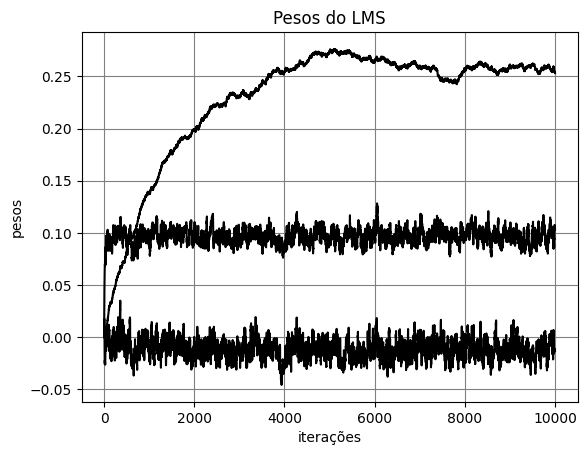

In [18]:
plt.figure()
# Mostra os pesos ao longo do treinamento
plt.plot(We, "k", label="LMS")
plt.xlabel("iterações")
plt.ylabel("pesos")
plt.grid(axis="x", color="0.5")
plt.grid(axis="y", color="0.5")
plt.title(
    "Pesos do LMS"
)

Por fim, vamos considerar o valor dos coeficientes na última iteração como sendo o modelo e testá-lo com dados de teste:

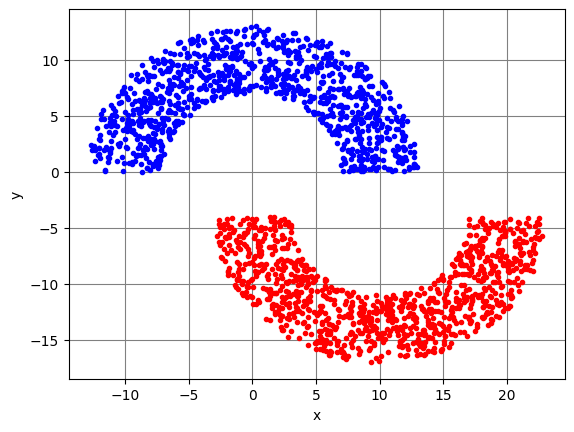

In [19]:
# Dados de teste
NAt = 1000
NBt = 1000
Nteste = NAt + NBt

dados_teste = meias_luas(NAt, NBt, r1, r2, r3)

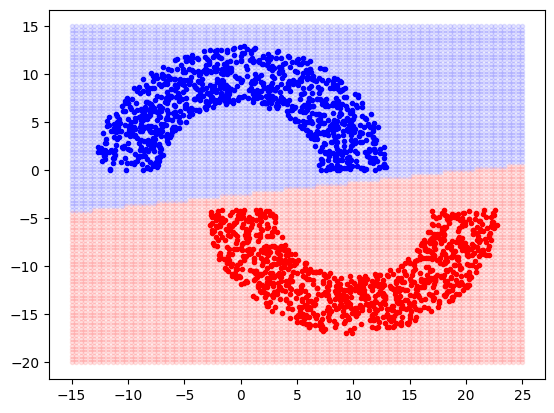

In [20]:
We_last = We[[-1], :].T

# Inserindo 1's no vetor de entrada
xteste = dados_teste[:, 0:2]  # sinal de entrada
b = np.ones((Nteste, 1))
xteste = np.hstack((b, xteste))
dteste = dados_teste[:, 2].reshape(-1, 1)  # sinal desejado
yteste = xteste @ We_last  # saída do filtro de Wiener considerando os dados de teste

# Gera a curva de separação das duas regiões
# Dados da curva de separação
Nsep = 100
x1S = np.linspace(-15, 25, Nsep).reshape(-1, 1)
x2S = np.linspace(-20, 15, Nsep).reshape(-1, 1)

# Gera pontos da grade
xx1S, xx2S = np.meshgrid(x1S, x2S)
xx1S = xx1S.reshape(-1, 1)
xx2S = xx2S.reshape(-1, 1)

# Gera array x
xgrid = np.hstack((xx1S, xx2S))
Ngrid = len(xgrid)
b = np.ones((Ngrid, 1))
xgrid = np.hstack((b, xgrid))

# Calcula saída para cada ponto da grade
ygrid = np.sign(xgrid @ We_last)

# Plota os pontos principais
fig, ax2 = plt.subplots()
for i in range(Nteste):
    if dteste[i] == 1:
        ax2.plot(xteste[i, 1], xteste[i, 2], ".b")
    else:
        ax2.plot(xteste[i, 1], xteste[i, 2], ".r")

# Plota pontos da grade com saída -1 (usa transparência alpha)
l0 = np.where(ygrid == -1)[0]
ax2.plot(xgrid[l0, 1], xgrid[l0, 2], "r.", alpha=0.1)

# Plota pontos da grade com saída 1 (usa transparência alpha)
l1 = np.where(ygrid == 1)[0]
ax2.plot(xgrid[l1, 1], xgrid[l1, 2], "b.", alpha=0.1)

## Exercício 3

Agora vamos implementar a regressão logística usando o MSE e função $\rm tanh$, com base no algoritmo implementado no Exercício 2. Para isso, precisamos da função tanh, que pode ser escrita como

$${\rm tanh} = \frac{e^{x}-e^{-x}}{e^{x}+e^{-x}}.$$

Dessa forma, a partir de um tipo dual capaz de realizar operações do tipo ``k**x``, com ``k`` constante e ``x`` dual, é possível implementar uma função ``tanh`` que funcione com variáveis duais.

Complemente a classe ``D`` implementada no exercício anterior com o método ``__rpow__`` que implementa a operação de potenciação à direita, para tratar de ``k**x``, com ``k`` constante e ``x`` dual. Utilize a função ``math.log`` para calcular o ${\rm ln}$ e leve em conta que a derivada da função exponencial é dada por

$$(k^{f(x)})' = k^{f(x)} \cdot {\rm ln}(k)f'(x).$$

In [23]:
#############
# Complete o código

def __rpow__(self, lhs):
        if not isinstance(lhs, D):
            lhs = D(lhs, 0)
        return lhs ** self


#############

Agora teste o tipo ``D`` com a exponencial:

In [24]:
x = 3
x_D = D(x, 2)

k = 2

y = k ** x_D # deve resultar em D(8, 8*ln(2)*2)
assert y.x == 8 and y.xd == 8 * math.log(2)*2

TypeError: unsupported operand type(s) for ** or pow(): 'int' and 'D'

Com o tipo ``D`` capaz de calcular a exponenciação, implemente a função tanh para lidar com tipos duais:

In [ ]:
#############
# Complete o código

# def tanh(x):
    # return
#############


Teste a função tanh, lembrando que $({\rm tanh(f(x))})' = (1 - tanh^2(f(x))) \cdot f'(x)$:

In [ ]:
x = 3
x_D = D(x, 2)

y = tanh(x_D) # deve resultar em D(tanh(x), (1 - tanh(x)**2) * 2)

np.testing.assert_array_almost_equal(y.x, np.tanh(x), decimal=6)
np.testing.assert_array_almost_equal(y.xd, (1 - (np.tanh(x))**2)*2, decimal=6)

Com a função ``tanh`` implementada e com base na função para o LMS construída anteriormente, implemente o algoritmo LMS para a regressão logística:

In [ ]:
def LMS_FILTER_estocastico_reglog_autodiff(x, d, eta, Nt):
    """
    y,e,W = LMS_FILTER_estocastico(x,d,eta,M,Nt)
    x: sinal de entrada
    d: sinal desejado
    eta: passo de adaptação
    Nt: número de dados de treinamento
    """
    M = 2
    # inserimos uma coluna de uns ao vetor de entrada para levar em conta o bias
    x = np.hstack((np.ones((Nt, 1)), x))

    W = np.zeros((Nt + 1, M + 1))

    #############
    # Complete o código


    #############


    return W

Por fim, vamos testar o algoritmo como fizemos no exercício 2:

In [ ]:
eta = 1e-3  # passo de adaptação do LMS
We = LMS_FILTER_estocastico_reglog_autodiff(xtreino, dtreino, eta, Nt)

In [ ]:
plt.figure()
# Mostra os pesos ao longo do treinamento
plt.plot(We, "k", label="LMS")
plt.xlabel("iterações")
plt.ylabel("pesos")
plt.grid(axis="x", color="0.5")
plt.grid(axis="y", color="0.5")
plt.title(
    "Pesos do LMS"
)


In [ ]:
We_last = We[[-1], :].T

# Inserindo 1's no vetor de entrada
xteste = dados_teste[:, 0:2]  # sinal de entrada
b = np.ones((Nteste, 1))
xteste = np.hstack((b, xteste))
dteste = dados_teste[:, 2].reshape(-1, 1)  # sinal desejado
yteste = xteste @ We_last  # saída do filtro de Wiener considerando os dados de teste

# Gera a curva de separação das duas regiões
# Dados da curva de separação
Nsep = 100
x1S = np.linspace(-15, 25, Nsep).reshape(-1, 1)
x2S = np.linspace(-20, 15, Nsep).reshape(-1, 1)

# Gera pontos da grade
xx1S, xx2S = np.meshgrid(x1S, x2S)
xx1S = xx1S.reshape(-1, 1)
xx2S = xx2S.reshape(-1, 1)

# Gera array x
xgrid = np.hstack((xx1S, xx2S))
Ngrid = len(xgrid)
b = np.ones((Ngrid, 1))
xgrid = np.hstack((b, xgrid))

# Calcula saída para cada ponto da grade
ygrid = np.sign(xgrid @ We_last)

# Plota os pontos principais
fig, ax2 = plt.subplots()
for i in range(Nteste):
    if dteste[i] == 1:
        ax2.plot(xteste[i, 1], xteste[i, 2], ".b")
    else:
        ax2.plot(xteste[i, 1], xteste[i, 2], ".r")

# Plota pontos da grade com saída -1 (usa transparência alpha)
l0 = np.where(ygrid == -1)[0]
ax2.plot(xgrid[l0, 1], xgrid[l0, 2], "r.", alpha=0.1)

# Plota pontos da grade com saída 1 (usa transparência alpha)
l1 = np.where(ygrid == 1)[0]
ax2.plot(xgrid[l1, 1], xgrid[l1, 2], "b.", alpha=0.1)